# Přísnost známkování na PISA 2018

Odhadni model ve Statě, následně spočítej rezidua v Pythonu a použij je k analýze.

Znovu to samé, ale teď pro rezidua s obráceným modelem: známka ~ skór + gender + escs

In [2]:
# nejake standardni importy
import os
import sys
import pyreadstat
import pandas as pd
import numpy as np
import re
from statsmodels.stats.weightstats import DescrStatsW
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
#import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt
# aby grafy byly rozumně čitelné na obrazovce
plt.rcParams['figure.dpi'] = 90
plt.rcParams['axes.titlesize'] = 11
#plt.ioff()

In [3]:
# cesta k datum
data_root = '/mnt/d/projects/idea/data'

In [4]:
sch18, sch18_meta = pyreadstat.read_sav(f'{data_root}/PISA/2018/CZ/CY07_MSU_SCH_QQQ_FINAL_CZ.sav')
stu18, stu18_meta = pyreadstat.read_sav(f'{data_root}/PISA/2018/CZ/CY07_MSU_STU_QQQ_FINAL_CZ.sav')

In [5]:
df = stu18[(stu18['ST001D01T'] == 9) & (stu18['STRATUMID_rec'] == 1)].copy()

In [6]:
df['ST800C01HA_CZ'] = df['ST800C01HA_CZ'].replace({6: np.nan})
df['ST800C02HA_CZ'] = df['ST800C02HA_CZ'].replace({6: np.nan})
df['ST800C04HA_CZ'] = df['ST800C04HA_CZ'].replace({6: np.nan})
df['ST800C05HA_CZ'] = df['ST800C05HA_CZ'].replace({6: np.nan})
df['ST800C06HA_CZ'] = df['ST800C06HA_CZ'].replace({6: np.nan})

In [7]:
df['MATH_MEAN'] = np.mean(df[[f'PV{i}MATH' for i in range(1,11)]], axis=1)
df['READ_MEAN'] = np.mean(df[[f'PV{i}READ' for i in range(1,11)]], axis=1)

In [8]:
foo = df.dropna(subset=['ESCS'])
dswe = DescrStatsW(foo['ESCS'], weights=foo['W_FSTUWT'])
df['ESCSz'] = (df['ESCS'] - dswe.mean) / dswe.std
df['ESCS_high'] = df['ESCS'] > 0

In [9]:
# ve Statě počítám taky nevážené PV u skórů, pro odhad na tom příliš nezáleží - pokud používám stejné z-skóry při odhadu i predikci
for i in range(1,11):
    df[f'PV{i}MATHz'] = (df[f'PV{i}MATH'] - df[f'PV{i}MATH'].mean()) / df[f'PV{i}MATH'].std()
    df[f'PV{i}READz'] = (df[f'PV{i}READ'] - df[f'PV{i}READ'].mean()) / df[f'PV{i}READ'].std()
    
df['MATH_Z'] = np.mean(df[[f'PV{i}MATHz' for i in range(1,11)]], axis=1)
df['READ_Z'] = np.mean(df[[f'PV{i}READz' for i in range(1,11)]], axis=1)

In [10]:
df['gr_matematika'] = np.where(df['ST800C01HA_CZ'] < 3, df['ST800C01HA_CZ'], np.where(df['ST800C01HA_CZ'] < 6, 8 - df['ST800C01HA_CZ'], np.nan))
df['gr_cestina'] = df['ST800C02HA_CZ']
df['girl'] = np.int_(df['ST004D01T'] == 1)

### Známky ~ skóry

```
-------------------------------------------------------------------------------
gr_matematika | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
--------------+----------------------------------------------------------------
        mathz |  -.5079904   .0270445   -18.78   0.000    -.5615527    -.454428
         girl |  -.3372834   .0500997    -6.73   0.000    -.4358147   -.2387522
        ESCSz |  -.1478415   .0239075    -6.18   0.000    -.1947578   -.1009251
        _cons |   2.703638   .0412585    65.53   0.000      2.62276    2.784516
-------------------------------------------------------------------------------

------------------------------------------------------------------------------
  gr_cestina | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
       readz |  -.3937293   .0248825   -15.82   0.000    -.4425728   -.3448858
        girl |  -.4211505   .0418484   -10.06   0.000    -.5031875   -.3391134
       ESCSz |  -.1541386   .0239628    -6.43   0.000    -.2011054   -.1071717
       _cons |   2.554044   .0439796    58.07   0.000     2.467845    2.640244
------------------------------------------------------------------------------
```

In [11]:
df['MATH_PRED'] = 2.703638 - .3372834 * df['girl'] - .5079904 * df['MATH_Z'] - .1478415 * df['ESCSz']
df['READ_PRED'] = 2.554044 - .4211505 * df['girl'] - .3937293 * df['READ_Z'] - .1541386 * df['ESCSz']

df['MATH_RESID'] = df['gr_matematika'] - df['MATH_PRED']
df['READ_RESID'] = df['gr_cestina'] - df['READ_PRED']

In [12]:
def nanaverage(x, weights=None):    
    if weights is None:
        if len(x.shape) == 1:
            return np.nanmean(x)
        else:
            res = np.nanmean(x, axis=0)
            return pd.Series(res, x.columns) if isinstance(x, pd.DataFrame) else res
    else:
        w = x[weights]
        x = x.drop(columns=[weights])
        mask = np.isnan(x)
        xm = np.ma.masked_array(x, mask=mask)
        if len(x.shape) == 1:
            return np.ma.average(xm, weights=w)
        else:
            res = np.ma.average(xm, weights=w, axis=0)
            return pd.Series(res, x.columns) if isinstance(x, pd.DataFrame) else res            

In [15]:
sch_resid = df.groupby('CNTSCHID')[['MATH_RESID', 'READ_RESID', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT')
sch_wr = pd.merge(sch18[['CNTSCHID', 'W_SCHGRNRABWT']], sch_resid.rename(columns={'MATH_RESID': 'MATH_SCHOOL_RESID', 'READ_RESID': 'READ_SCHOOL_RESID'}).reset_index())

In [16]:
dswm = DescrStatsW(sch_wr['MATH_SCHOOL_RESID'], weights=sch_wr['W_SCHGRNRABWT'])
dswr = DescrStatsW(sch_wr['READ_SCHOOL_RESID'], weights=sch_wr['W_SCHGRNRABWT'])

qsm = dswm.quantile([0.2, 0.4, 0.6, 0.8])
qsr = dswr.quantile([0.2, 0.4, 0.6, 0.8])

sch_wr['MATH_SCHOOL_BIN'] = pd.cut(sch_wr['MATH_SCHOOL_RESID'], [-np.inf] + list(qsm) + [np.inf], labels=False)
sch_wr['READ_SCHOOL_BIN'] = pd.cut(sch_wr['READ_SCHOOL_RESID'], [-np.inf] + list(qsr) + [np.inf], labels=False)

In [17]:
df = pd.merge(df, sch_wr)

<AxesSubplot:xlabel='MATH_SCHOOL_RESID', ylabel='READ_SCHOOL_RESID'>

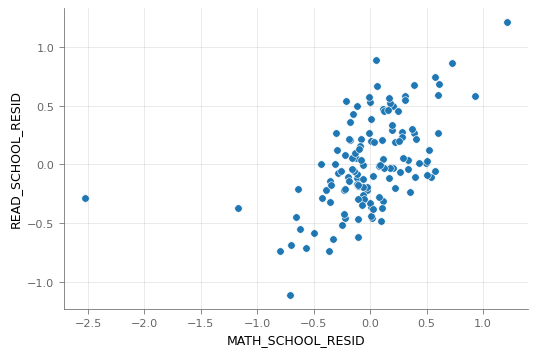

In [18]:
sns.scatterplot(x='MATH_SCHOOL_RESID', y='READ_SCHOOL_RESID', data=sch_wr)

In [19]:
df[['MATH_SCHOOL_RESID', 'READ_SCHOOL_RESID']].corr()

,MATH_SCHOOL_RESID,READ_SCHOOL_RESID
MATH_SCHOOL_RESID,1.000000,0.523566
READ_SCHOOL_RESID,0.523566,1.000000


## Grafy pro studii

Co všechno chci?

Základní deskriptivy
- četnosti známek, kluci vs dívky
- boxplot skóry podle známek (včetně plausible values)
- průměrné skóry podle známek

Pro pět skupin přísnosti známkování:
- četnosti známek
- průměrné skóry podle známek 
- očekávání vystudování VŠ podle známek
- očekávaný status zaměstnání ve 30 podle známek


### Graf č. 1 - boxplot skórů

In [20]:
for i in range(1, 11):
    df[f'math_score_{i}'] = df[f'PV{i}MATH']
dfl = pd.wide_to_long(df, 'math_score', sep='_', j='pv', i=['CNTSTUID'])
df = df.drop(columns=[f'math_score_{i}' for i in range(1, 11)])

In [28]:
plt.rcParams['figure.figsize'] = 10, 5

In [38]:
quantiles = dfl.groupby('gr_matematika')['math_score'].quantile(q=[0.05, 0.25, 0.5, 0.75, 0.95]).unstack()
quantiles.to_csv('output/prisnost-znamkovani/graf1_data.csv', index=False)
quantiles

,0.05,0.25,0.50,0.75,0.95
gr_matematika,,,,,
1.0,414.86920,496.95675,543.3720,589.85000,658.84620
2.0,390.62620,459.56700,507.9785,554.06650,618.60450
3.0,340.12995,407.70575,451.5330,502.11225,569.28295
4.0,311.54170,377.89625,423.9050,472.29375,532.49765
5.0,279.23590,364.91625,405.9275,446.11350,519.09170


In [39]:
dfl['math_score'].quantile(q=[0.05, 0.25, 0.5, 0.75, 0.95])

0.05    344.85490
0.25    423.99825
0.50    480.67250
0.75    537.23925
0.95    610.71985
Name: math_score, dtype: float64

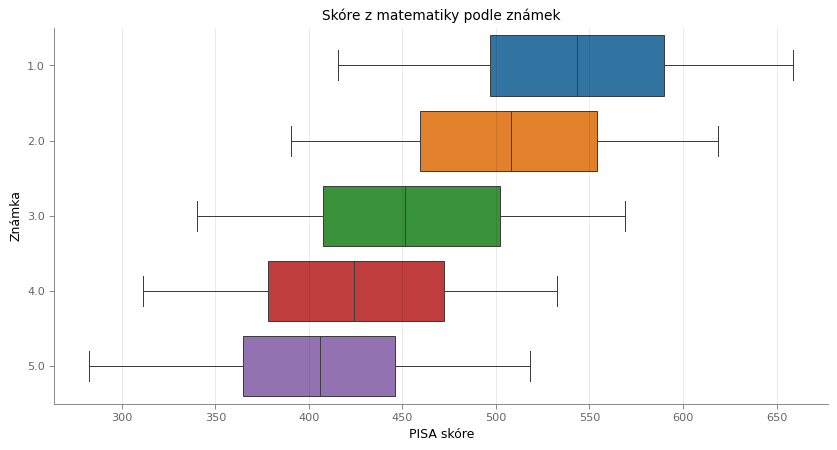

In [41]:
ax = sns.boxplot(y='gr_matematika', x='math_score', data=dfl, orient='h', whis=[5, 95], showfliers=False)
ax.set_title('Skóre z matematiky podle známek')
ax.set(xlabel='PISA skóre', ylabel='Známka')
ax.get_figure().savefig('output/prisnost-znamkovani/graf1.png')
ax.get_figure().savefig('output/prisnost-znamkovani/graf1.pdf')

[Text(0.5, 0, 'PISA skóre'), Text(0, 0.5, 'Známka')]

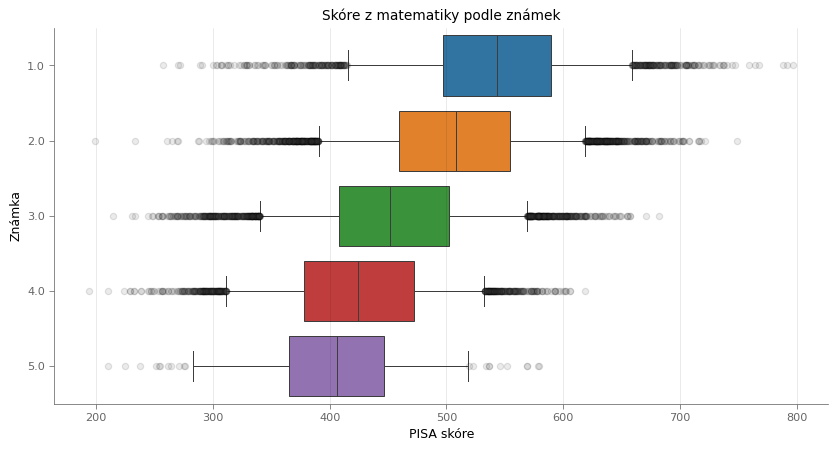

In [35]:
ax = sns.boxplot(y='gr_matematika', x='math_score', data=dfl, orient='h', whis=[5, 95], flierprops={'markeredgecolor': 'black', 'marker': 'o', 'alpha': 0.1})
ax.set_title('Skóre z matematiky podle známek')
ax.set(xlabel='PISA skóre', ylabel='Známka')

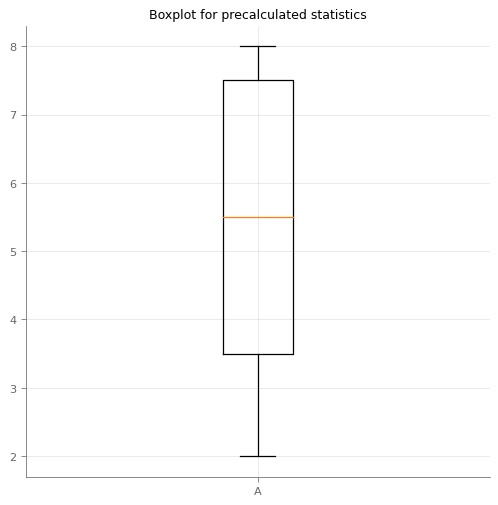

In [40]:

stats = [{
    "label": 'A',  # not required
    "mean":  5,  # not required
    "med": 5.5,
    "q1": 3.5,
    "q3": 7.5,
    # "cilo": 5.3 # not required
    # "cihi": 5.7 # not required
    "whislo": 2.0,  # required
    "whishi": 8.0,  # required
    "fliers": []  # required if showfliers=True
    }]

fs = 10  # fontsize

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6), sharey=True)
axes.bxp(stats)
axes.set_title('Boxplot for precalculated statistics', fontsize=fs)
plt.show()

Text(0.5, 1.0, 'Četnosti známek z matematiky')

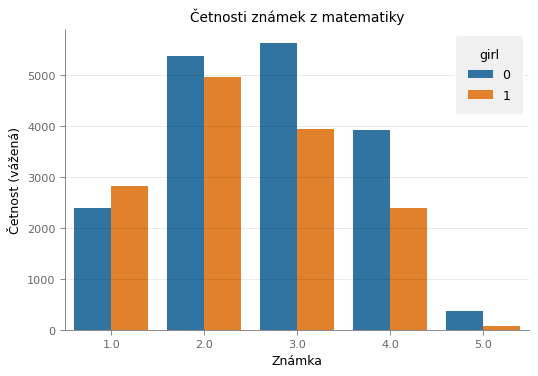

In [22]:
foo = df.groupby(['gr_matematika', 'girl'])['W_FSTUWT'].sum().reset_index()
ax = sns.barplot(x='gr_matematika', y='W_FSTUWT', hue='girl', data=foo)
ax.set(xlabel='Známka', ylabel='Četnost (vážená)')
ax.set_title('Četnosti známek z matematiky')

Text(0.5, 1.0, 'Průměrné testové skóry v matematice podle známek')

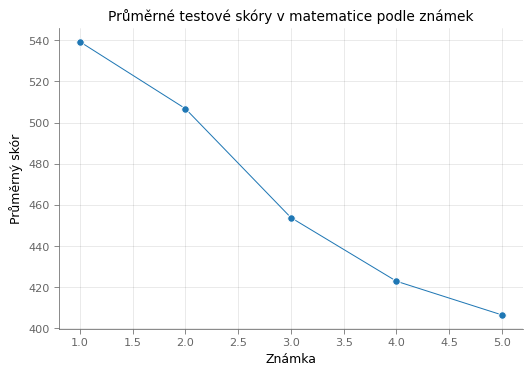

In [25]:
foo = df.groupby('gr_matematika')[['MATH_MEAN', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
ax = sns.lineplot(x='gr_matematika', y='MATH_MEAN', data=foo, marker='o')
ax.set(xlabel='Známka', ylabel='Průměrný skór')
ax.set_title('Průměrné testové skóry v matematice podle známek')

In [26]:
foo

,gr_matematika,MATH_MEAN
0,1.0,539.261364
1,2.0,506.757413
2,3.0,453.829567
3,4.0,422.936598
4,5.0,406.562235


[Text(0.5, 0, 'PISA skóre'),
 Text(0, 0.5, 'Přísnost (0 = nejméně přísné, 4 = nejvíce přísné)')]

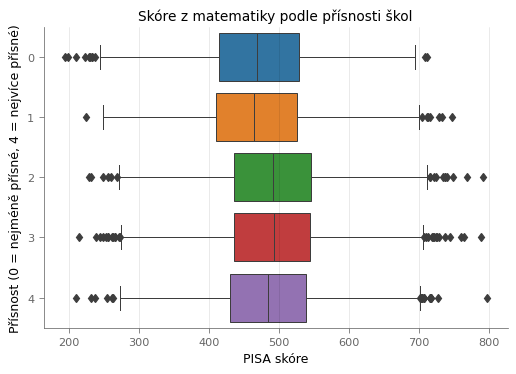

In [54]:
ax = sns.boxplot(y='MATH_SCHOOL_BIN', x='math_score', data=dfl, orient='h')
ax.set_title('Skóre z matematiky podle přísnosti škol')
ax.set(xlabel='PISA skóre', ylabel='Přísnost (0 = nejméně přísné, 4 = nejvíce přísné)')

[Text(0.5, 0, 'Známka'),
 Text(0, 0.5, 'Průměrný skór'),
 Text(0.5, 1.0, 'Průměrné testové skóry z matematiky podle známek a přísnosti škol')]

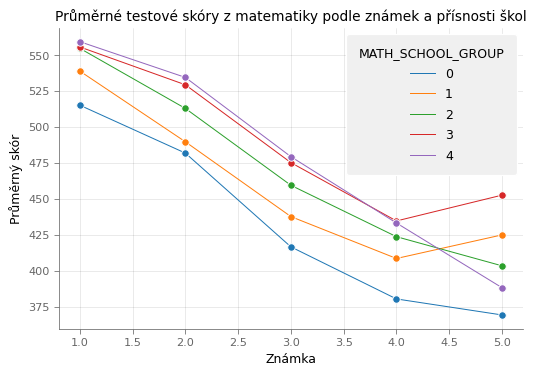

In [56]:
# df.groupby(['gr_matematika', 'SCH_BIN', 'ST225Q06HA'])['CNTSTUID'].count()
foo = df.groupby(['gr_matematika', 'MATH_SCHOOL_BIN'])[['MATH_MEAN', 'ST225Q06HA', 'BSMJ', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
foo['MATH_SCHOOL_GROUP'] = pd.Categorical(foo['MATH_SCHOOL_BIN'])
ax = sns.lineplot(x='gr_matematika', y='MATH_MEAN', data=foo, hue='MATH_SCHOOL_GROUP', marker='o')
ax.set(xlabel='Známka', ylabel='Průměrný skór', title='Průměrné testové skóry z matematiky podle známek a přísnosti škol')

[Text(0.5, 1.0, 'Podíl žáků, který očekává vystudování VŠ'),
 Text(0.5, 0, 'Známka'),
 Text(0, 0.5, 'Podíl žáků')]

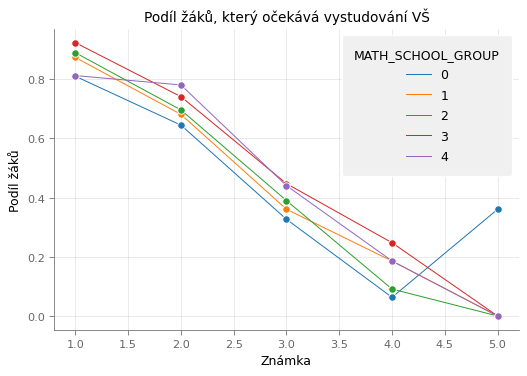

In [57]:
ax = sns.lineplot(x='gr_matematika', y='ST225Q06HA', data=foo, hue='MATH_SCHOOL_GROUP', marker='o')
ax.set(title='Podíl žáků, který očekává vystudování VŠ', xlabel='Známka', ylabel='Podíl žáků')

[Text(0.5, 1.0, 'Status očekávaného zaměstnání ve 30 letech'),
 Text(0.5, 0, 'Známka'),
 Text(0, 0.5, 'Index BSMJ')]

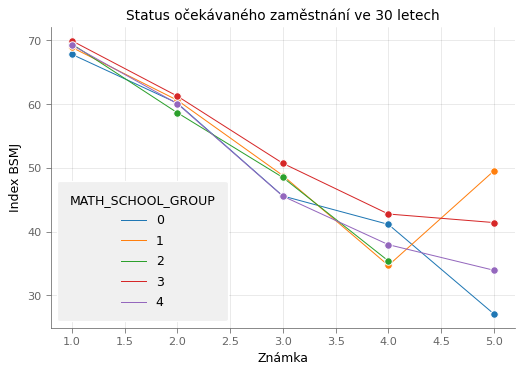

In [58]:
ax = sns.lineplot(x='gr_matematika', y='BSMJ', data=foo, hue='MATH_SCHOOL_GROUP', marker='o')
ax.set(title='Status očekávaného zaměstnání ve 30 letech', xlabel='Známka', ylabel='Index BSMJ')

[Text(0.5, 0, 'Známka'), Text(0, 0.5, 'Relativní četnost')]

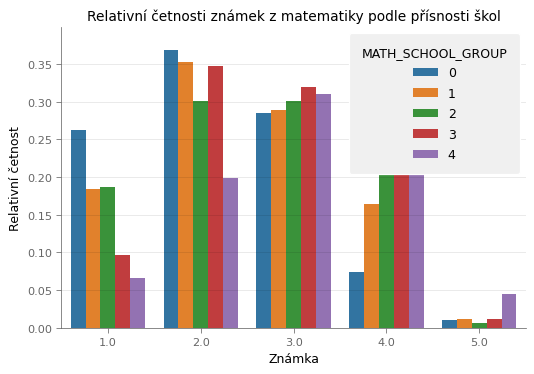

In [55]:
foo = df.groupby(['gr_matematika', 'MATH_SCHOOL_BIN'])['W_FSTUWT'].sum().reset_index()
foo = pd.merge(foo, foo.groupby('MATH_SCHOOL_BIN')['W_FSTUWT'].sum().rename('W_FSTUWT_TOTAL').reset_index())
foo['MATH_SCHOOL_GROUP'] = pd.Categorical(foo['MATH_SCHOOL_BIN'])
foo['rel_weight'] = foo['W_FSTUWT'] / foo['W_FSTUWT_TOTAL']
ax = sns.barplot(x='gr_matematika', y='rel_weight', hue='MATH_SCHOOL_GROUP', data=foo)
ax.set_title('Relativní četnosti známek z matematiky podle přísnosti škol')
ax.set(xlabel='Známka', ylabel='Relativní četnost')

## Vypadá to tak i v češtině?

In [47]:
for i in range(1, 11):
    df[f'read_score_{i}'] = df[f'PV{i}READ']
dfl = pd.wide_to_long(df, 'read_score', sep='_', j='pv', i=['CNTSTUID'])
df = df.drop(columns=[f'read_score_{i}' for i in range(1, 11)])

[Text(0.5, 0, 'PISA skóre'), Text(0, 0.5, 'Přísnost')]

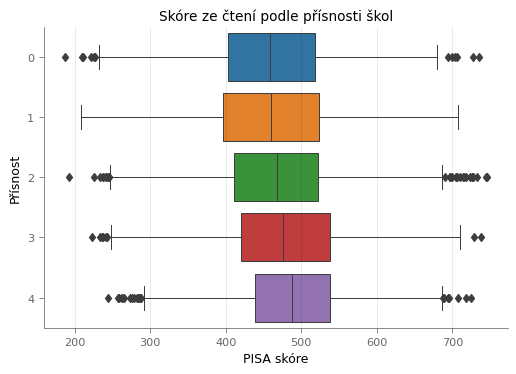

In [49]:
ax = sns.boxplot(y='READ_SCHOOL_BIN', x='read_score', data=dfl, orient='h')
ax.set_title('Skóre ze čtení podle přísnosti škol')
ax.set(xlabel='PISA skóre', ylabel='Přísnost')

<AxesSubplot:xlabel='gr_cestina', ylabel='W_FSTUWT'>

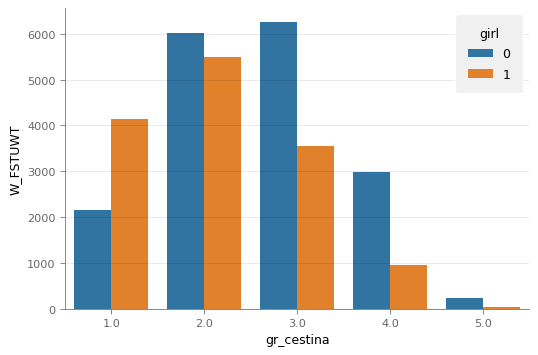

In [40]:
foo = df.groupby(['gr_cestina', 'girl'])['W_FSTUWT'].sum().reset_index()
sns.barplot(x='gr_cestina', y='W_FSTUWT', hue='girl', data=foo)

<AxesSubplot:xlabel='gr_cestina', ylabel='READ_MEAN'>

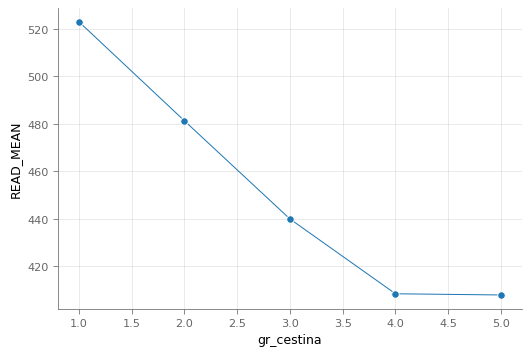

In [41]:
foo = df.groupby('gr_cestina')[['READ_MEAN', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
sns.lineplot(x='gr_cestina', y='READ_MEAN', data=foo, marker='o')

<AxesSubplot:xlabel='gr_cestina', ylabel='READ_MEAN'>

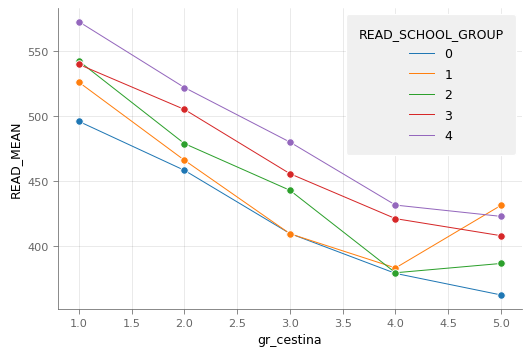

In [42]:
# df.groupby(['gr_matematika', 'SCH_BIN', 'ST225Q06HA'])['CNTSTUID'].count()
foo = df.groupby(['gr_cestina', 'READ_SCHOOL_BIN'])[['READ_MEAN', 'ST225Q06HA', 'BSMJ', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
foo['READ_SCHOOL_GROUP'] = pd.Categorical(foo['READ_SCHOOL_BIN'])
sns.lineplot(x='gr_cestina', y='READ_MEAN', data=foo, hue='READ_SCHOOL_GROUP', marker='o')

<AxesSubplot:xlabel='gr_cestina', ylabel='ST225Q06HA'>

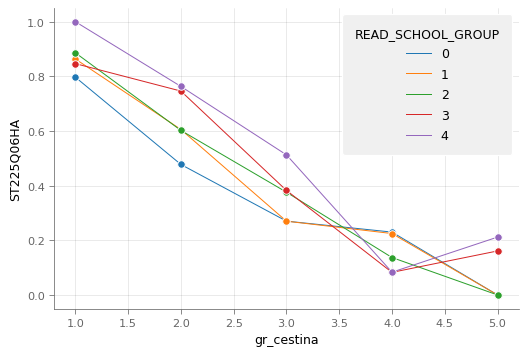

In [43]:
sns.lineplot(x='gr_cestina', y='ST225Q06HA', data=foo, hue='READ_SCHOOL_GROUP', marker='o')

<AxesSubplot:xlabel='gr_cestina', ylabel='BSMJ'>

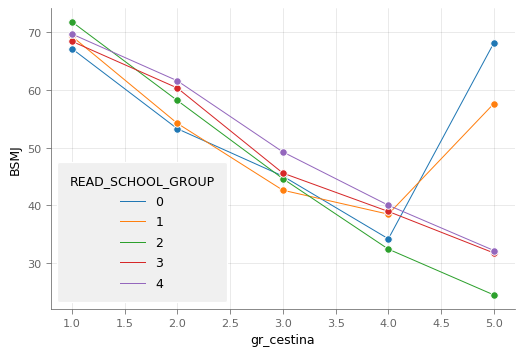

In [44]:
sns.lineplot(x='gr_cestina', y='BSMJ', data=foo, hue='READ_SCHOOL_GROUP', marker='o')

<AxesSubplot:xlabel='gr_cestina', ylabel='rel_weight'>

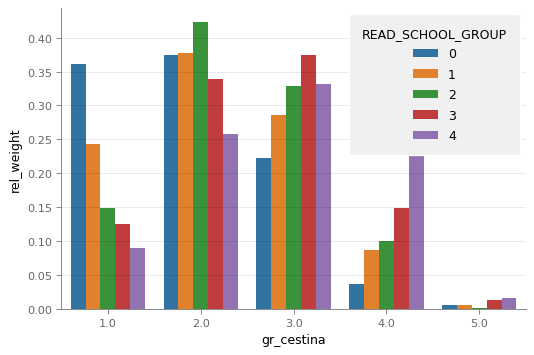

In [45]:
foo = df.groupby(['gr_cestina', 'READ_SCHOOL_BIN'])['W_FSTUWT'].sum().reset_index()
foo = pd.merge(foo, foo.groupby('READ_SCHOOL_BIN')['W_FSTUWT'].sum().rename('W_FSTUWT_TOTAL').reset_index())
foo['READ_SCHOOL_GROUP'] = pd.Categorical(foo['READ_SCHOOL_BIN'])
foo['rel_weight'] = foo['W_FSTUWT'] / foo['W_FSTUWT_TOTAL']
sns.barplot(x='gr_cestina', y='rel_weight', hue='READ_SCHOOL_GROUP', data=foo)

## Science

In [61]:
df = df[(np.isfinite(df['ST800C04HA_CZ'])) & (df['ST800C04HA_CZ'] <= 5) & (np.isfinite(df['ST800C05HA_CZ'])) & (df['ST800C05HA_CZ'] <= 5) & (np.isfinite(df['ST800C06HA_CZ'])) & (df['ST800C06HA_CZ'] <= 5)].copy()

In [62]:
df.shape

(1869, 768)

In [64]:
df['SCIE_MEAN'] = np.mean(df[[f'PV{i}SCIE' for i in range(1,11)]], axis=1)

<AxesSubplot:xlabel='ST800C04HA_CZ', ylabel='SCIE_MEAN'>

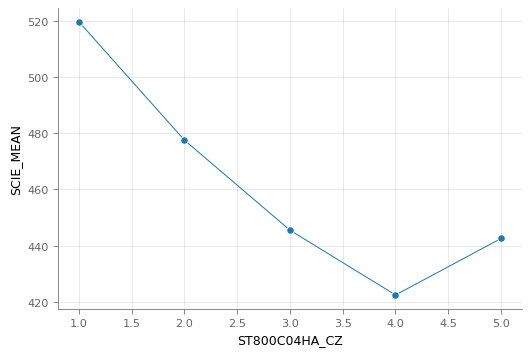

In [65]:
# FYZIKA
foo = df.groupby('ST800C04HA_CZ')[['SCIE_MEAN', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
sns.lineplot(x='ST800C04HA_CZ', y='SCIE_MEAN', data=foo, marker='o')

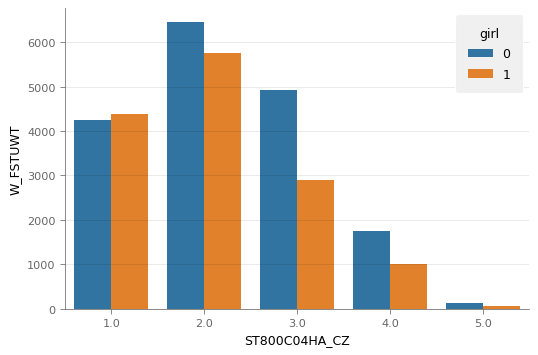

In [66]:
foo = df.groupby(['ST800C04HA_CZ', 'girl'])['W_FSTUWT'].sum().reset_index()
ax = sns.barplot(x='ST800C04HA_CZ', y='W_FSTUWT', hue='girl', data=foo)

<AxesSubplot:xlabel='ST800C05HA_CZ', ylabel='SCIE_MEAN'>

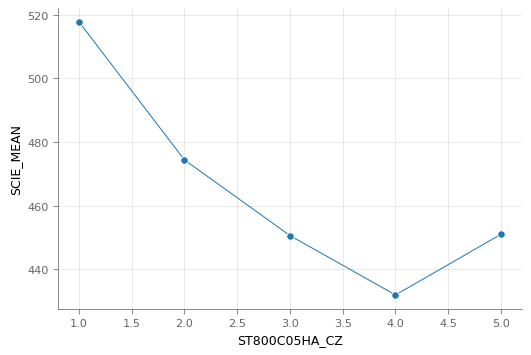

In [67]:
# CHEMIE
foo = df.groupby('ST800C05HA_CZ')[['SCIE_MEAN', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
sns.lineplot(x='ST800C05HA_CZ', y='SCIE_MEAN', data=foo, marker='o')

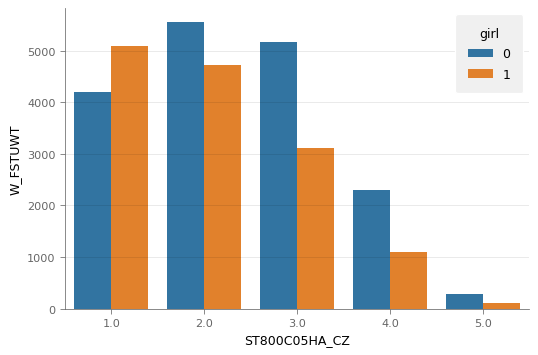

In [68]:
foo = df.groupby(['ST800C05HA_CZ', 'girl'])['W_FSTUWT'].sum().reset_index()
ax = sns.barplot(x='ST800C05HA_CZ', y='W_FSTUWT', hue='girl', data=foo)

<AxesSubplot:xlabel='ST800C06HA_CZ', ylabel='SCIE_MEAN'>

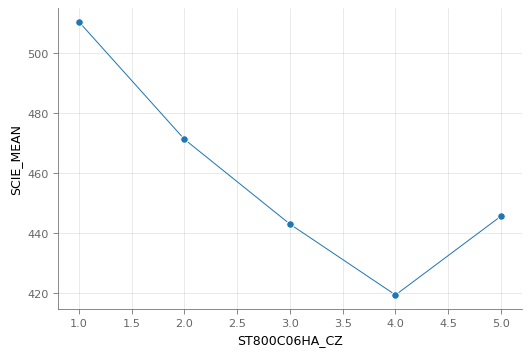

In [69]:
# PŘÍRODOVĚDA
foo = df.groupby('ST800C06HA_CZ')[['SCIE_MEAN', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
sns.lineplot(x='ST800C06HA_CZ', y='SCIE_MEAN', data=foo, marker='o')

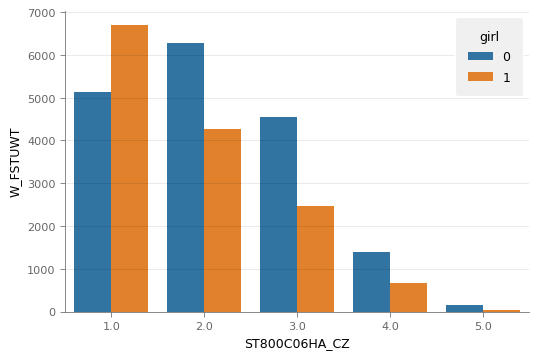

In [70]:
foo = df.groupby(['ST800C06HA_CZ', 'girl'])['W_FSTUWT'].sum().reset_index()
ax = sns.barplot(x='ST800C06HA_CZ', y='W_FSTUWT', hue='girl', data=foo)

In [71]:
df['gr_science'] = (df['ST800C04HA_CZ'] + df['ST800C05HA_CZ'] + df['ST800C06HA_CZ']) / 3

```
------------------------------------------------------------------------------
  gr_science | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
       sciez |  -.3404235   .0230278   -14.78   0.000    -.3859765   -.2948705
        girl |  -.3406425   .0405931    -8.39   0.000    -.4203461   -.2609389
       ESCSz |  -.1795881   .0217758    -8.25   0.000    -.2222751   -.1369011
       _cons |    2.27221   .0364118    62.40   0.000     2.200823    2.343596
------------------------------------------------------------------------------
```

In [72]:
for i in range(1,11):
    df[f'PV{i}SCIEz'] = (df[f'PV{i}SCIE'] - df[f'PV{i}SCIE'].mean()) / df[f'PV{i}SCIE'].std()
df['SCIE_Z'] = np.mean(df[[f'PV{i}SCIEz' for i in range(1,11)]], axis=1)

In [73]:
df['SCIE_PRED'] = 2.27221 - .3406425 * df['girl'] - .3404235 * df['SCIE_Z'] - .1795881 * df['ESCSz']
df['SCIE_RESID'] = df['gr_science'] - df['SCIE_PRED']

In [74]:
sch_resid = df.groupby('CNTSCHID')[['SCIE_RESID', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT')
sch_wr = pd.merge(sch18[['CNTSCHID', 'W_SCHGRNRABWT']], sch_resid.rename(columns={'SCIE_RESID': 'SCIE_SCHOOL_RESID'}).reset_index())

dsws = DescrStatsW(sch_wr['SCIE_SCHOOL_RESID'], weights=sch_wr['W_SCHGRNRABWT'])
qss = dsws.quantile([0.2, 0.4, 0.6, 0.8])
sch_wr['SCIE_SCHOOL_BIN'] = pd.cut(sch_wr['SCIE_SCHOOL_RESID'], [-np.inf] + list(qss) + [np.inf], labels=False)

In [75]:
df = pd.merge(df, sch_wr.drop(columns=['W_SCHGRNRABWT']))

Text(0.5, 1.0, 'Průměrné testové skóry v science podle známek')

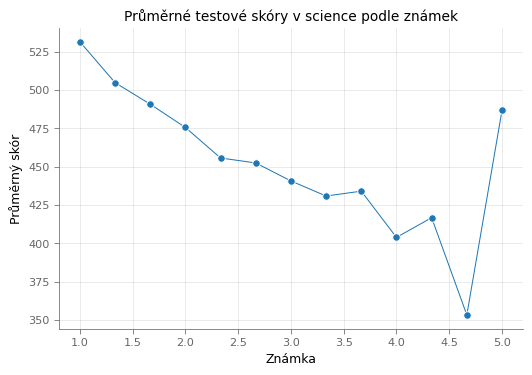

In [76]:
foo = df.groupby('gr_science')[['SCIE_MEAN', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
ax = sns.lineplot(x='gr_science', y='SCIE_MEAN', data=foo, marker='o')
ax.set(xlabel='Známka', ylabel='Průměrný skór')
ax.set_title('Průměrné testové skóry v science podle známek')

In [77]:
for i in range(1, 11):
    df[f'scie_score_{i}'] = df[f'PV{i}SCIE']
dfl = pd.wide_to_long(df, 'scie_score', sep='_', j='pv', i=['CNTSTUID'])
df = df.drop(columns=[f'scie_score_{i}' for i in range(1, 11)])

[Text(0.5, 0, 'PISA skóre'),
 Text(0, 0.5, 'Přísnost (0 = nejméně přísné, 4 = nejvíce přísné)')]

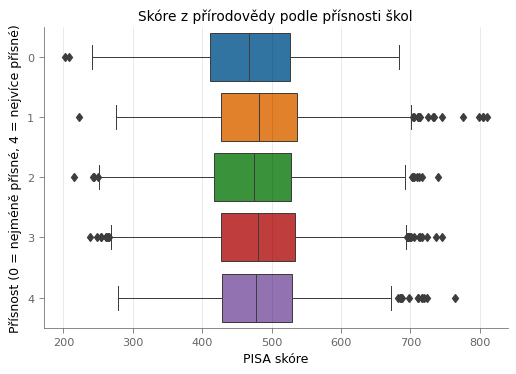

In [78]:
ax = sns.boxplot(y='SCIE_SCHOOL_BIN', x='scie_score', data=dfl, orient='h')
ax.set_title('Skóre z přírodovědy podle přísnosti škol')
ax.set(xlabel='PISA skóre', ylabel='Přísnost (0 = nejméně přísné, 4 = nejvíce přísné)')

Text(0.5, 1.0, 'Četnosti známek ze science')

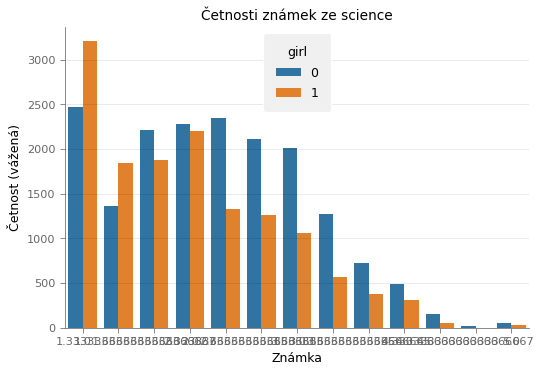

In [79]:
foo = df.groupby(['gr_science', 'girl'])['W_FSTUWT'].sum().reset_index()
ax = sns.barplot(x='gr_science', y='W_FSTUWT', hue='girl', data=foo)
ax.set(xlabel='Známka', ylabel='Četnost (vážená)')
ax.set_title('Četnosti známek ze science')

[Text(0.5, 0, 'Známka'),
 Text(0, 0.5, 'Průměrný skór'),
 Text(0.5, 1.0, 'Průměrné testové skóry ze science podle známek a přísnosti škol')]

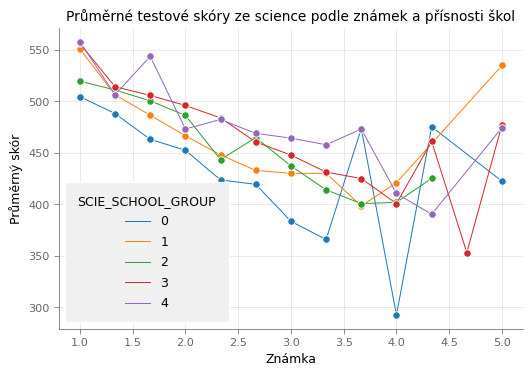

In [80]:
# df.groupby(['gr_matematika', 'SCH_BIN', 'ST225Q06HA'])['CNTSTUID'].count()
foo = df.groupby(['gr_science', 'SCIE_SCHOOL_BIN'])[['SCIE_MEAN', 'ST225Q06HA', 'BSMJ', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
foo['SCIE_SCHOOL_GROUP'] = pd.Categorical(foo['SCIE_SCHOOL_BIN'])
ax = sns.lineplot(x='gr_science', y='SCIE_MEAN', data=foo, hue='SCIE_SCHOOL_GROUP', marker='o')
ax.set(xlabel='Známka', ylabel='Průměrný skór', title='Průměrné testové skóry ze science podle známek a přísnosti škol')

[Text(0.5, 1.0, 'Podíl žáků, který očekává vystudování VŠ'),
 Text(0.5, 0, 'Známka'),
 Text(0, 0.5, 'Podíl žáků')]

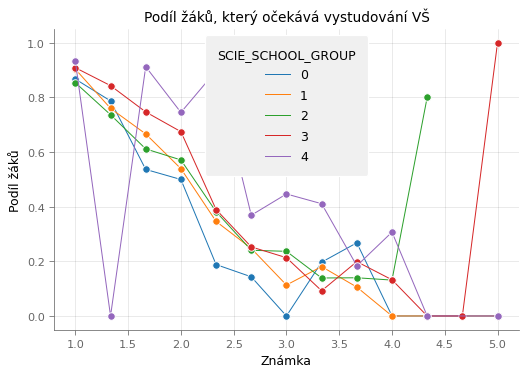

In [81]:
ax = sns.lineplot(x='gr_science', y='ST225Q06HA', data=foo, hue='SCIE_SCHOOL_GROUP', marker='o')
ax.set(title='Podíl žáků, který očekává vystudování VŠ', xlabel='Známka', ylabel='Podíl žáků')

[Text(0.5, 1.0, 'Status očekávaného zaměstnání ve 30 letech'),
 Text(0.5, 0, 'Známka'),
 Text(0, 0.5, 'Index BSMJ')]

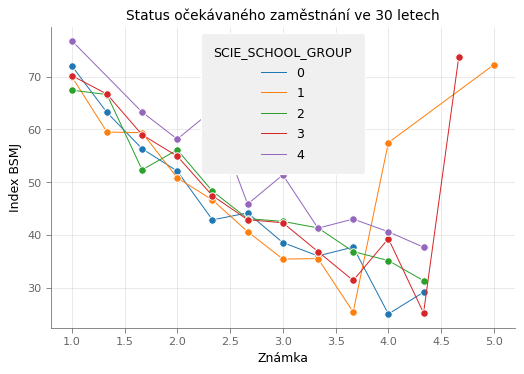

In [82]:
ax = sns.lineplot(x='gr_science', y='BSMJ', data=foo, hue='SCIE_SCHOOL_GROUP', marker='o')
ax.set(title='Status očekávaného zaměstnání ve 30 letech', xlabel='Známka', ylabel='Index BSMJ')

In [83]:
df['gr_science_int'] = np.round(df['gr_science'])

Text(0.5, 1.0, 'Průměrné testové skóry v science podle známek')

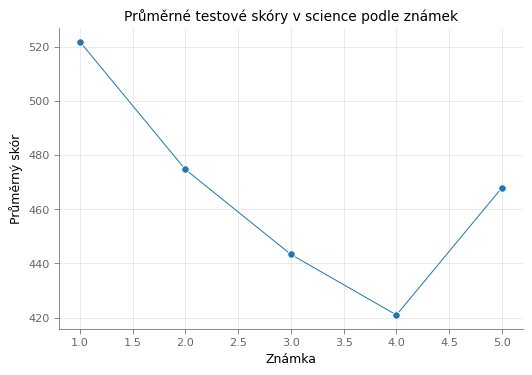

In [84]:
foo = df.groupby('gr_science_int')[['SCIE_MEAN', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
ax = sns.lineplot(x='gr_science_int', y='SCIE_MEAN', data=foo, marker='o')
ax.set(xlabel='Známka', ylabel='Průměrný skór')
ax.set_title('Průměrné testové skóry v science podle známek')

Text(0.5, 1.0, 'Četnosti známek ze science')

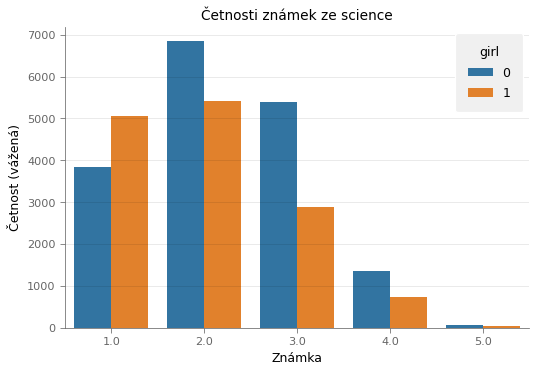

In [85]:
foo = df.groupby(['gr_science_int', 'girl'])['W_FSTUWT'].sum().reset_index()
ax = sns.barplot(x='gr_science_int', y='W_FSTUWT', hue='girl', data=foo)
ax.set(xlabel='Známka', ylabel='Četnost (vážená)')
ax.set_title('Četnosti známek ze science')

[Text(0.5, 0, 'Známka'),
 Text(0, 0.5, 'Průměrný skór'),
 Text(0.5, 1.0, 'Průměrné testové skóry ze science podle známek a přísnosti škol')]

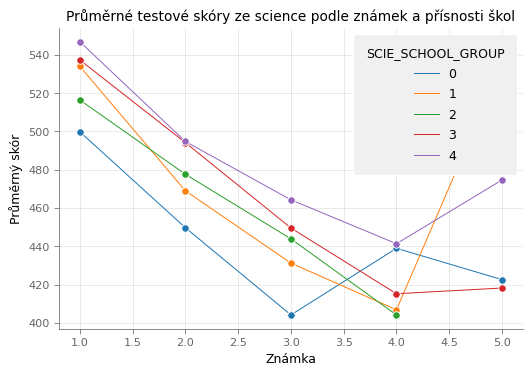

In [86]:
# df.groupby(['gr_matematika', 'SCH_BIN', 'ST225Q06HA'])['CNTSTUID'].count()
foo = df.groupby(['gr_science_int', 'SCIE_SCHOOL_BIN'])[['SCIE_MEAN', 'ST225Q06HA', 'BSMJ', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
foo['SCIE_SCHOOL_GROUP'] = pd.Categorical(foo['SCIE_SCHOOL_BIN'])
ax = sns.lineplot(x='gr_science_int', y='SCIE_MEAN', data=foo, hue='SCIE_SCHOOL_GROUP', marker='o')
ax.set(xlabel='Známka', ylabel='Průměrný skór', title='Průměrné testové skóry ze science podle známek a přísnosti škol')

[Text(0.5, 1.0, 'Podíl žáků, který očekává vystudování VŠ'),
 Text(0.5, 0, 'Známka'),
 Text(0, 0.5, 'Podíl žáků')]

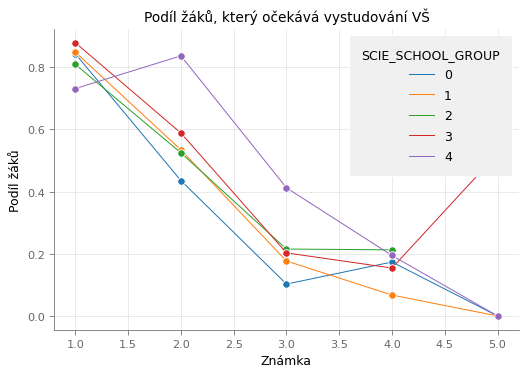

In [87]:
ax = sns.lineplot(x='gr_science_int', y='ST225Q06HA', data=foo, hue='SCIE_SCHOOL_GROUP', marker='o')
ax.set(title='Podíl žáků, který očekává vystudování VŠ', xlabel='Známka', ylabel='Podíl žáků')

[Text(0.5, 1.0, 'Status očekávaného zaměstnání ve 30 letech'),
 Text(0.5, 0, 'Známka'),
 Text(0, 0.5, 'Index BSMJ')]

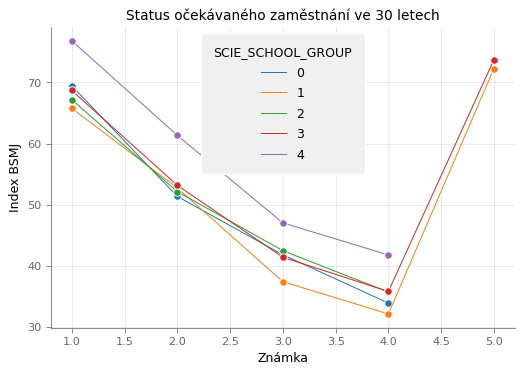

In [88]:
ax = sns.lineplot(x='gr_science_int', y='BSMJ', data=foo, hue='SCIE_SCHOOL_GROUP', marker='o')
ax.set(title='Status očekávaného zaměstnání ve 30 letech', xlabel='Známka', ylabel='Index BSMJ')

## LHS vs RHS?

Znovu vidím rozdíly podle toho, jestli dám známky na RHS nebo LHS -> gender bias in grading depends on it. To už jsem ale řešil při paperu, ne? Co byl tehdy přesně ten důvod?

In [41]:
df.shape

(1878, 738)

<AxesSubplot:xlabel='gr_matematika', ylabel='MATH_MEAN'>

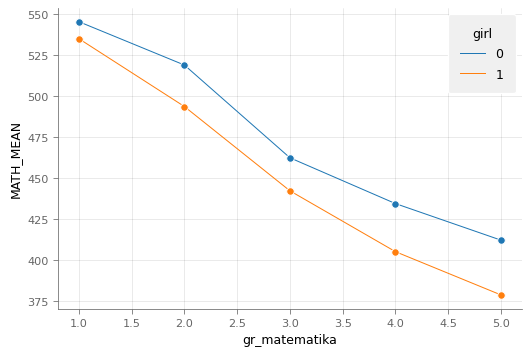

In [45]:
foo = df.groupby(['gr_matematika', 'girl'])[['MATH_MEAN', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
sns.lineplot(x='gr_matematika', y='MATH_MEAN', data=foo, hue='girl', marker='o')

<AxesSubplot:xlabel='gr_cestina', ylabel='READ_MEAN'>

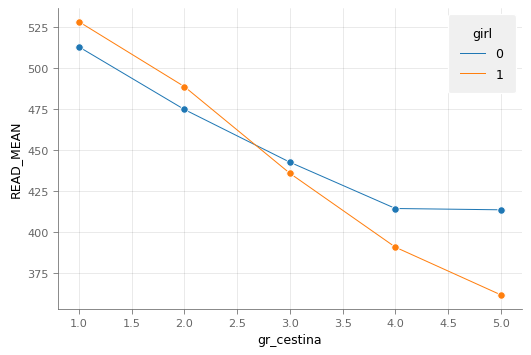

In [46]:
foo = df.groupby(['gr_cestina', 'girl'])[['READ_MEAN', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
sns.lineplot(x='gr_cestina', y='READ_MEAN', data=foo, hue='girl', marker='o')

In [59]:
foo = df.dropna(subset=['ESCS'])
dswe = DescrStatsW(foo['ESCS'], weights=foo['W_FSTUWT'])
df['ESCSz'] = (df['ESCS'] - dswe.mean) / dswe.std
df['ESCS_high'] = df['ESCS'] > 0

In [57]:
dswm = DescrStatsW(df['MATH_MEAN'], weights=df['W_FSTUWT'])
dswr = DescrStatsW(df['READ_MEAN'], weights=df['W_FSTUWT'])

qs = [i / 10 for i in range(1, 10)]
qsm = dswm.quantile(qs)
qsr = dswr.quantile(qs)

df['MATH_BIN'] = pd.cut(df['MATH_MEAN'], [-np.inf] + list(qsm) + [np.inf], labels=False)
df['READ_BIN'] = pd.cut(df['READ_MEAN'], [-np.inf] + list(qsr) + [np.inf], labels=False)

<AxesSubplot:xlabel='MATH_MEAN', ylabel='gr_matematika'>

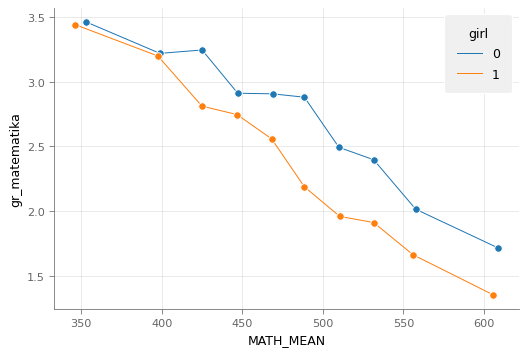

In [58]:
foo = df.groupby(['MATH_BIN', 'girl'])[['MATH_MEAN', 'gr_matematika', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
sns.lineplot(x='MATH_MEAN', y='gr_matematika', data=foo, hue='girl', marker='o')

<AxesSubplot:xlabel='READ_MEAN', ylabel='gr_cestina'>

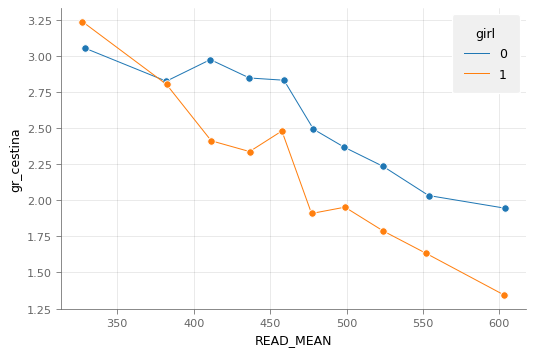

In [60]:
foo = df.groupby(['READ_BIN', 'girl'])[['READ_MEAN', 'gr_cestina', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
sns.lineplot(x='READ_MEAN', y='gr_cestina', data=foo, hue='girl', marker='o')

<AxesSubplot:xlabel='MATH_MEAN', ylabel='gr_matematika'>

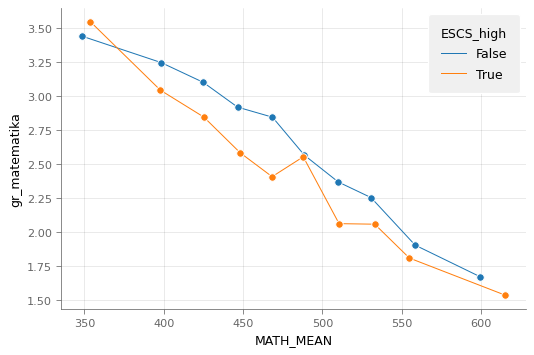

In [61]:
foo = df.groupby(['MATH_BIN', 'ESCS_high'])[['MATH_MEAN', 'gr_matematika', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
sns.lineplot(x='MATH_MEAN', y='gr_matematika', data=foo, hue='ESCS_high', marker='o')

<AxesSubplot:xlabel='READ_MEAN', ylabel='gr_cestina'>

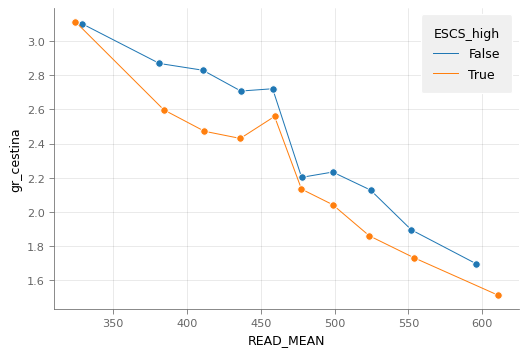

In [62]:
foo = df.groupby(['READ_BIN', 'ESCS_high'])[['READ_MEAN', 'gr_cestina', 'W_FSTUWT']].apply(nanaverage, weights='W_FSTUWT').reset_index()
sns.lineplot(x='READ_MEAN', y='gr_cestina', data=foo, hue='ESCS_high', marker='o')